# Convolutional MNIST VAE

## Installation 

In [1]:
!mkdir figures
!mkdir scripts
%cd /content/scripts

# !wget -q https://raw.githubusercontent.com/probml/pyprobml/master/vae/standalone/lvm_plots_utils.py
# !wget -q https://raw.githubusercontent.com/probml/pyprobml/master/vae/standalone/vae_conv_mnist.py
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/vae-mnist-conv-latent-dim-2.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/vae-mnist-conv-latent-dim-20.ckpt

mkdir: cannot create directory ‘figures’: File exists
mkdir: cannot create directory ‘scripts’: File exists
[Errno 2] No such file or directory: '/content/scripts'
/home/patel_zeel/AQ-NewsArticles/ProbML/pyprobml-1/notebooks/book1/20


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch

try:
    from torchvision.utils import make_grid
except ModuleNotFoundError:
    %pip install -qq torchvision
    from torchvision.utils import make_grid

import torch.nn as nn
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

try:
    from pytorch_lightning import LightningModule, Trainer
except ModuleNotFoundError:
    %pip install -qq pytorch-lightning
    from pytorch_lightning import LightningModule, Trainer

try:
    from einops import rearrange
except ModuleNotFoundError:
    %pip install -qq einops
    from einops import rearrange

try:
    import probml_utils
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils

from probml_utils import savefig

from probml_utils.lvm_plots_utils import (
    get_random_samples,
    get_grid_samples,
    plot_scatter_plot,
    get_imrange,
    plot_grid_plot,
    plot_scatter_plot,
)

import seaborn as sns
from torchvision.utils import make_grid
from probml_utils.vae_conv_mnist import ConvVAE

%pip install -qq test-tube umap

Note: you may need to restart the kernel to use updated packages.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
mnist_full = MNIST(
    ".", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])
)
dm = DataLoader(mnist_full, batch_size=250)
vis_data = DataLoader(mnist_full, batch_size=5000)
batch = next(iter(vis_data))

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## VAE

In [6]:
m = ConvVAE(
    (1, 28, 28), encoder_conv_filters=[28, 64, 64], decoder_conv_t_filters=[64, 28, 1], latent_dim=20, kl_coeff=5
)
m2 = ConvVAE(
    (1, 28, 28), encoder_conv_filters=[28, 64, 64], decoder_conv_t_filters=[64, 28, 1], latent_dim=2, kl_coeff=5
)

In [7]:
m.load_state_dict(torch.load("vae-mnist-conv-latent-dim-20.ckpt"))
m2.load_state_dict(torch.load("vae-mnist-conv-latent-dim-2.ckpt"))

<All keys matched successfully>

In [8]:
m.eval()
m.to(device)
m2.eval()
m2.to(device)

ConvVAE(
  (vae): ConvVAEModule(
    (enc_convs): ModuleList(
      (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(28, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
    )
    (mu_linear): Linear(in_features=1024, out_features=2, bias=True)
    (log_var_linear): Linear(in_features=1024, out_features=2, bias=True)
    (decoder_linear): Linear(in_features=2, out_features=1024, bias=True)
    (dec_t_convs): ModuleList(
      (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
      (3): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (4): ConvTranspose2d(64, 28, kernel_size=(3, 3), stride=(1, 1), padd

## Reconstruction

### ConvVAE with latent dim 20

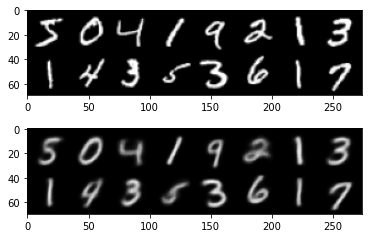

In [ ]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs = plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), "c h w -> h w c"))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(m.vae(imgs)[0].cpu()), "c h w -> h w c"))
savefig("vae_mnist_conv_20d_rec.pdf")
plt.show()

In [ ]:
!ls

figures		      pyprobml_utils.py    vae_conv_mnist.py.2
lvm_plots_utils.py    pyprobml_utils.py.1  vae_mnist_conv_20d_rec.pdf
lvm_plots_utils.py.1  pyprobml_utils.py.2  vae-mnist-conv-latent-dim-20.ckpt
lvm_plots_utils.py.2  scripts		   vae-mnist-conv-latent-dim-2.ckpt
MNIST		      vae_conv_mnist.py    vae-mnist-conv-latent-dim-2.ckpt.1
__pycache__	      vae_conv_mnist.py.1  vae-mnist-conv-latent-dim-2.ckpt.2


### ConvVAE with latent dim 2

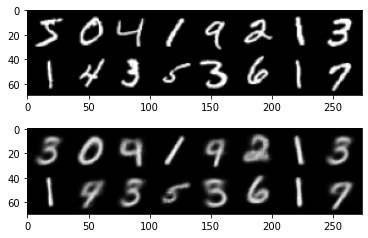

In [ ]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs = plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), "c h w -> h w c"))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(m2.vae(imgs)[0].cpu()), "c h w -> h w c"))
savefig("vae_mnist_conv_2d_rec.pdf")
plt.show()

## Sampling

### Random samples form truncated unit normal distribution

We sample $z \sim TN(0,1)$ form a truncated normal distribution with a threshold = 5

#### ConvVAE with latent dim 20

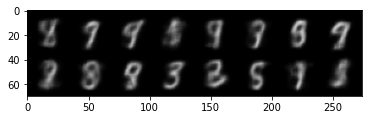

In [ ]:
def decoder(z):
    return m.vae.decode(z)


plt.figure()
# imgs= get_random_samples(decoder, truncation_threshold=5)
imgs = get_random_samples(decoder, truncation_threshold=5, num_images_per_row=8, num_images=16)
plt.imshow(imgs)
savefig("vae_mnist_conv_20d_samples.pdf")

#### ConvVAE with latent dim 2

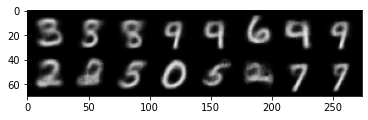

In [ ]:
def decoder(z):
    return m2.vae.decode(z)


plt.figure()
imgs = get_random_samples(decoder, truncation_threshold=5, latent_dim=2, num_images_per_row=8, num_images=16)
plt.imshow(imgs)
savefig("vae_mnist_conv_2d_samples.pdf")

### Grid Sampling

We let $z = [z1, z2, 0, \ldots, 0]$ and vary $z1, z2$ on a grid

#### ConvVAE with latent dim 20

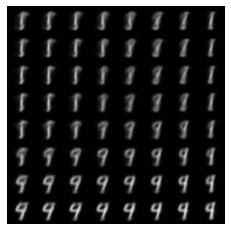

In [ ]:
def decoder(z):
    return m.vae.decode(z)[0]


# plt.figure(figsize=(10,10))
plt.figure()
# plt.imshow(rearrange(make_grid(get_grid_samples(decoder, 20), 10), " c h w -> h w c").cpu())
nimgs = 8
nlatents = 20
plt.imshow(rearrange(make_grid(get_grid_samples(decoder, nlatents, nimgs), nimgs), " c h w -> h w c").cpu())
plt.axis("off")
plt.tight_layout()
savefig("vae_mnist_conv_20d_grid.pdf")

#### ConvVAE with latent dim 2

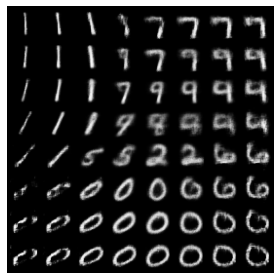

In [ ]:
def decoder(z):
    return m2.vae.decode(z)[0]


plt.figure()
nimgs = 8
nlatents = 2
plt.imshow(rearrange(make_grid(get_grid_samples(decoder, nlatents, nimgs), nimgs), " c h w -> h w c").cpu())
plt.axis("off")
plt.tight_layout()
savefig("vae_mnist_conv_2d_grid.pdf")

## 2D Color embedding of latent space

### ConvVAE with latent dim 20

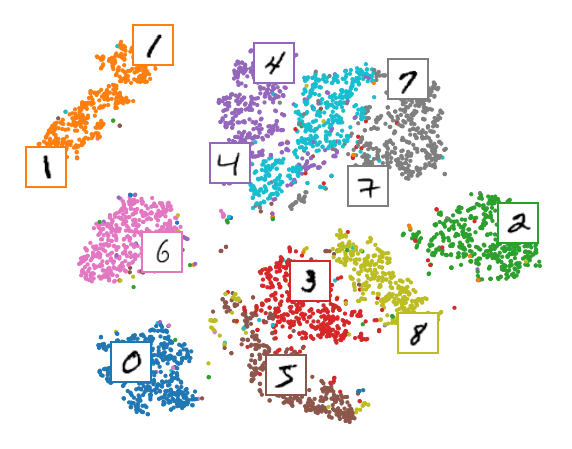

In [ ]:
def encoder(img):
    return m.vae.encode(img)[0]


def decoder(z):
    z = z.to(device)
    return rearrange(m.vae.decode(z), "b c h w -> b (c h) w")


plot_scatter_plot(batch, encoder)

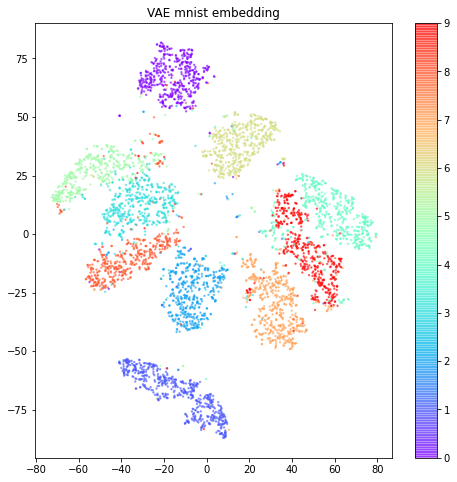

In [ ]:
def encoder(img):
    return m.vae.encode(img)[0]


def decoder(z):
    z = z.to(device)
    return rearrange(m.vae.decode(z), "b c h w -> b (c h) w")


fig = plot_grid_plot(batch, encoder)
savefig("vae_mnist_conv_20d_embed.pdf")
plt.show()

### ConvVAE with latent dim 2

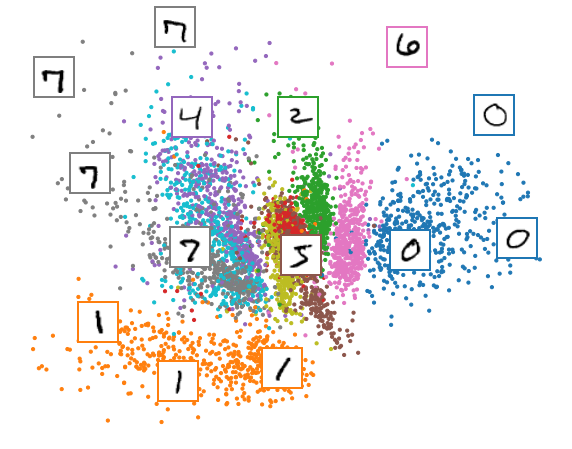

In [ ]:
def encoder(img):
    return m2.vae.encode(img)[0].cpu().detach().numpy()


def decoder(z):
    z = z.to(device)
    return rearrange(m2.vae.decode(z), "b c h w -> b (c h) w")


plot_scatter_plot(batch, encoder)

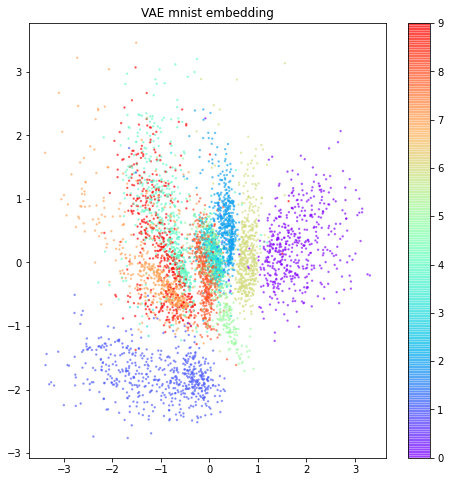

In [ ]:
fig = plot_grid_plot(batch, encoder)
savefig("vae_mnist_conv_2d_embed.pdf")

## Interpolation 

### Spherical Interpolation

#### ConvVAE with latent dim 20

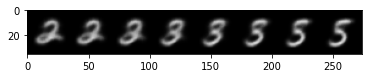

In [ ]:
def decoder(z):
    z = z.to(device)
    return rearrange(m.vae.decode(z), "b c h w -> b (c h) w")


def encoder(img):
    return m.vae.encode(img)[0].cpu().detach()


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
# end, start = z_imgs[1], z_imgs[3]
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder, start, end, interpolation="spherical")
plt.imshow(arr)
savefig("vae_mnist_conv_20d_spherical.pdf")

#### ConvVAE with latent dim 2

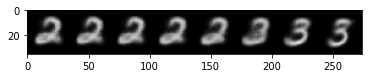

In [ ]:
def decoder(z):
    z = z.to(device)
    return rearrange(m2.vae.decode(z), "b c h w -> b (c h) w")


def encoder(img):
    return m2.vae.encode(img)[0].cpu().detach()


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder, start, end, interpolation="spherical")
plt.imshow(arr)
savefig("vae_mnist_conv_2d_spherical.pdf")

### Linear Interpolation

#### ConvVAE with latent dim 20

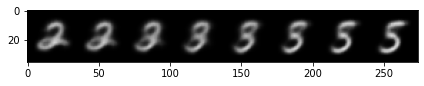

In [ ]:
def decoder(z):
    z = z.to(device)
    return rearrange(m.vae.decode(z), "b c h w -> b (c h) w")


def encoder(img):
    return m.vae.encode(img)[0].cpu().detach()


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder, start, end, interpolation="linear")
plt.imshow(arr)
plt.tight_layout()
savefig("vae_mnist_conv_20d_linear.pdf")

#### ConvVAE with latent dim 2

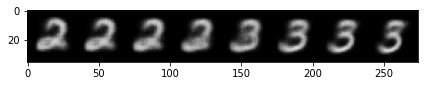

In [ ]:
def decoder(z):
    z = z.to(device)
    return rearrange(m2.vae.decode(z), "b c h w -> b (c h) w")


def encoder(img):
    return m2.vae.encode(img)[0].cpu().detach()


imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
# end, start = z_imgs[1], z_imgs[3]
end, start = z_imgs[0], z_imgs[5]

plt.figure()
arr = get_imrange(decoder, start, end, interpolation="linear")
plt.imshow(arr)
plt.tight_layout()
savefig("vae_mnist_conv_2d_linear.pdf")